In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import torch
import time
from tqdm.autonotebook import tqdm
from scipy import signal
import time
%matplotlib inline
import pickle

In [2]:
from cUtils import *
from Rfuns import bw_nrd0_R
from tmpUtils import *

In [3]:
dataPath = Path("../data")

### Load the Amat from real data

In [5]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [6]:
realPath = dataPath/"realmat.pkl"
if realPath.exists():
    with open(realPath, "rb") as f:
        real = pickle.load(f)
else:
    datF = list(dataPath.glob("*.mat"))[0]
    rawDat = loadmat(datF)
    dat = rawDat["DK_timecourse"]
    fs = 600
    q = 50
    nDat = mat2Tensor(dat, fs=fs, q=q)
    bandsCuts = [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]]
    downrates = [1, 1]
    hs = [0.1, 0.1]
    T = 60
    _, dF, dT = nDat.Y.shape
    times = np.linspace(0, T, dT)
    freqs = np.array([np.mean(bandCut) for bandCut in bandsCuts])
    Amat = GetAmatTorch(torch.tensor(nDat.Y.copy()), torch.tensor(nDat.X.copy()), times, freqs, downrates, hs)
    
    res = np.linalg.eig(Amat)
    absEigVs = np.abs(res[0])
    # Sort the eigvs and vectors such that the vals is in order
    sortIdx = np.argsort(absEigVs)[::-1]
    lams = res[0][sortIdx]
    U = res[1][:, sortIdx]
    
    real = edict()
    real["Amat"] = Amat
    real["U"] = U
    real["eigVs"] = lams
    real["X"] = nDat.X
    real["Y"] = nDat.Y
    
    with open(realPath, "wb") as f:
        pickle.dump(real, f)

In [7]:
AmatRM = np.random.randn(68, 68)
res = np.linalg.eig(AmatRM)
U = res[1]
eigVs = res[0]
# U = real.U
# eigVs = real.eigVs

In [8]:
dF = 5
dT = 100
nR = 6
T = 6
ChgsFreq = [3]
ChgsT = [10, 50, 80]
d = U.shape[0]

In [9]:
eigIndAll = eigVs.imag != 0
ChgsTF = np.concatenate([[0], ChgsT, [dT]])
ChgsFreqF = np.concatenate([[0], ChgsFreq, [dF]])
ChgsFreqF = ChgsFreqF.astype(np.int)
ChgsTF = ChgsTF.astype(np.int)

In [10]:
eigIndAll[:nR]

array([ True,  True,  True,  True, False, False])

In [11]:
Mus = GenFVecs(nR, eigIndAll[:nR], ChgsFreqF)
Nus = GenFVecs(nR, eigIndAll[:nR], ChgsTF)
idx1 = ChgsFreqF[1]
Mus[:, 0:idx1].imag = 0
stdMus =  Mus /np.linalg.norm(Mus, axis=1).reshape(-1, 1)

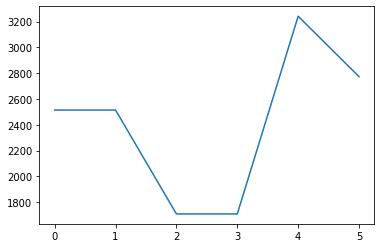

In [12]:
tMNs = stdMus.reshape(-1, 1, 5) * Nus.reshape(nR, -1, 1)
plt.plot(np.abs(tMNs).sum(axis=(1, 2)))

In [13]:
num = 68
X = np.random.randn(num, dF, dT)
#X = real.X[:num, :dF, :dT]
Y = np.zeros_like(X)
U = U[:num, :num]
invU = np.linalg.inv(U)
tAmat = 0
tAmats = ddict(list)
cAr = np.random.randint(0, 100, (num, num))
pEigVs = stdMus[:, 0] * Nus[:, 0]
for df in range(dF):
    for dt in range(dT):
        cX = X[:, df, dt]
        cMu = stdMus[:, df]
        cNu = Nus[:, dt]
        pEigVs = cMu * cNu
        # sortIdx = np.argsort(np.abs(pEigVs))[::-1]
        cEigVs = np.diag(np.concatenate([pEigVs, np.zeros(num - len(cMu))]))
        cA = np.matmul(np.matmul(U, cEigVs), invU)
        cAr = cA.real # theroetically, imag part should be 0
        cY = np.matmul(cAr, cX) #+ 0*np.random.randn(d)
        Y[:, df, dt] = cY
        tAmats[df].append(cAr)
        tAmat = cAr + tAmat

### Test the Amat

In [14]:
d, dF, dT = X.shape
T = 6
bandsCuts = [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]]
times = np.linspace(0, T, dT)
freqs = np.array([np.mean(bandCut) for bandCut in bandsCuts])
hs = [bw_nrd0_R(freqs), bw_nrd0_R(times)]
print(hs)
# hs = [10, 0.5]

[7.788676982805086, 0.6299827082211206]


In [15]:
Xt = torch.tensor(X)
Yt = torch.tensor(Y)
Amat = GetAmatTorch(Yt[:, :, :], Xt[:, :, :], times, freqs, [1, 2], hs=hs)

In [16]:
res = np.linalg.eig(Amat)
lam = np.diag(res[0])
eU = res[1]
einvU = np.linalg.inv(eU)
np.linalg.norm(np.sum(np.abs(einvU[:6, :]), axis=0) - np.sum(np.abs(invU[:6, :]), axis=0))

5.3229270602184995

[0 1 2 3 4 5]


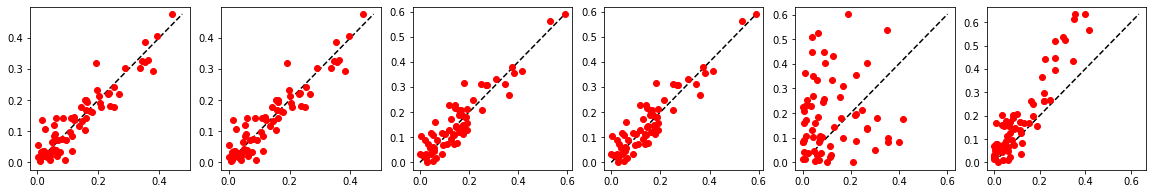

In [17]:
nrow = 6
pU = einvU[:nrow, :]
ptU = invU[:nrow, :]
rords = matchU(pU, ptU)
# rords = np.array([0, 1, 2, 3, 4, 5])
print(rords)
rptU = ptU[rords]
fig, axs = plt.subplots(1, 6, figsize=(20,3))
for i in range(nrow):
    cpU = pU[i, :].real
    cptU = rptU[i, :].real
    mv = np.max([np.abs(cpU).max(), np.abs(cptU).max()])
    xs = ys = np.linspace(0, mv, 1000)
    axs[i].plot(xs, ys, ls='--',c='k')
    axs[i].plot(np.abs(cpU), np.abs(cptU), "ro", label=f"Vector {i+1}")
    
# plt.legend()

### Full alg

In [20]:
fs = 600
Rn = 6
T = 6
bandsCuts = [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]]
times = np.linspace(0, T, dT)
freqs = np.array([np.mean(bandCut) for bandCut in bandsCuts])
hs = [bw_nrd0_R(freqs), bw_nrd0_R(times)]

lams = [1e1, 1e1]
downrates = [1, 4]
q = 50
iterNums = [100, 100]
iterCs = [1e-6, 1e-6]
As = [2.7, 2.7]
alps = [0.9, 0.9]
outIterC = 1e-6
betas = [1, 1]

In [21]:
fOpt = TVDNextOpt(rawDat=None, fs=fs, T=T, hs=hs, Rn=Rn, lams=lams, downrates=downrates, q=q, 
                  iterNums=iterNums, iterCs=iterCs, As=As, alps=alps,
                  outIterC=outIterC, maxIter=1000, betas=betas)
fOpt.X = torch.tensor(X)
fOpt.Y = torch.tensor(Y)

In [22]:
fOpt(True, maxIter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [35]:
reidx = np.array([0, 3, 1, 4, 6, 9, 7, 10], dtype=np.int)

In [36]:
eMus = fOpt.lastOptMu.GamMatStd.cpu().numpy()
eThetas = fOpt.lastOptMu.ThetaMatStd.cpu().numpy()
tMus = np.concatenate([stdMus.real, stdMus.imag])[reidx, :]
eDiffMus = np.diff(eMus)

([], [])

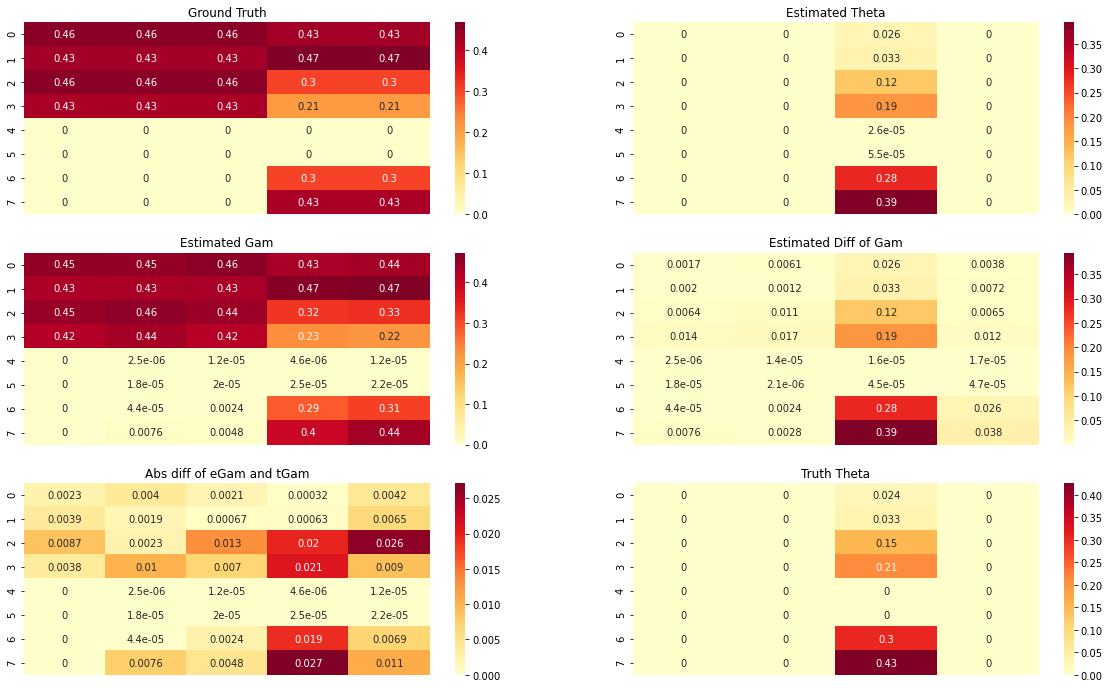

In [38]:
plt.figure(figsize=[20, 12])

is_annot = True
plt.subplot(321)
plt.title("Ground Truth")
sns.heatmap(np.abs(tMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(323)
plt.title("Estimated Gam")
sns.heatmap(np.abs(eMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(325)
plt.title("Abs diff of eGam and tGam")
sns.heatmap(np.abs(np.abs(tMus)-np.abs(eMus)), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(322)
plt.title("Estimated Theta")
sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(324)
plt.title("Estimated Diff of Gam")
sns.heatmap(np.abs(eDiffMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(326)
plt.title("Truth Theta")
sns.heatmap(np.abs(np.diff(tMus)), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

In [39]:
eNus = fOpt.lastOptNu.GamMat.cpu().numpy()
eThetas = fOpt.lastOptNu.ThetaMat.cpu().numpy()
tNus = np.concatenate([Nus.real, Nus.imag])[reidx, :]
eDiffNus = np.diff(eNus)

([], [])

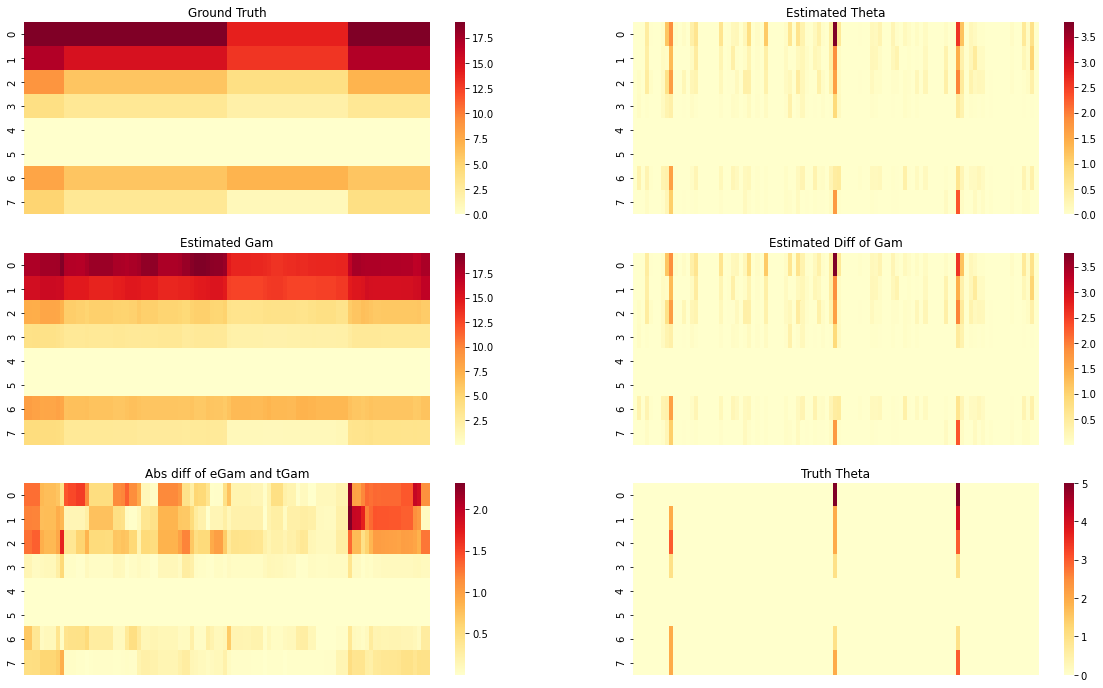

In [40]:
plt.figure(figsize=[20, 12])

is_annot = False
plt.subplot(321)
plt.title("Ground Truth")
sns.heatmap(np.abs(tNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(323)
plt.title("Estimated Gam")
sns.heatmap(np.abs(eNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(325)
plt.title("Abs diff of eGam and tGam")
sns.heatmap(np.abs(np.abs(tNus)-np.abs(eNus)), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(322)
plt.title("Estimated Theta")
sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(324)
plt.title("Estimated Diff of Gam")
sns.heatmap(np.abs(eDiffNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(326)
plt.title("Truth Theta")
sns.heatmap(np.abs(np.diff(tNus)), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])